## Model Checking I: Posterior predictive check
The technique implemented here answers the following problems:
1. Are the model and parameters estimated a good fit for the underlying data?
2. Given two separate models, which is a better fit for the underlying data?

In [54]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt
from IPython.display import Image

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

In [55]:
messages = pd.read_csv('hangout_chat_data.csv')
messages.head()

,conversation_id,event_id,timestamp,sender,message_length,num_participants,message_type,prev_timestamp,prev_sender,time_delay_seconds,time_delay_mins,day_of_week,year_month,is_weekend
0,Ugw5Xrm3ZO5mzAfKB7V4AaABAQ,7-H0Z7-FkyB7-HDBYj4KKh,2014-08-15 03:44:12.840015,Mark Regan,14,3,TEXT,2014-08-15 03:44:00.781653,Keir Alexander,12.0,1.0,4,2014-08,0
1,UgwLUkm5oqPrUyjqFlR4AaABAQ,85SWvmXIEV285Sb1E65xL0,2015-10-18 09:36:39.438706,Mark Regan,47,4,TEXT,2015-10-18 09:36:10.932367,Louise Regan,28.0,1.0,6,2015-10,1
2,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1JJEmE5K,2013-12-19 02:49:28.552063,Mark Regan,44,2,TEXT,2013-12-19 02:48:50.916592,Daragh Walsh,37.0,1.0,3,2013-12,0
3,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1NQV6lMv,2013-12-19 02:50:02.249113,Mark Regan,29,2,TEXT,2013-12-19 02:49:50.401824,Daragh Walsh,11.0,1.0,3,2013-12,0
4,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1RPd1OTh,2013-12-19 02:50:34.906922,Mark Regan,102,2,TEXT,2013-12-19 02:50:11.427353,Daragh Walsh,23.0,1.0,3,2013-12,0


In [56]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=100)
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)

    y_pred = pm.Poisson('y_pred', mu=mu)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if __name__ == '__main__':
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [y_pred]
>Metropolis: [mu]


Sampling 2 chains for 1_000 tune and 200_000 draw iterations (2_000 + 400_000 draws total) took 107 seconds.
The number of effective samples is smaller than 10% for some parameters.


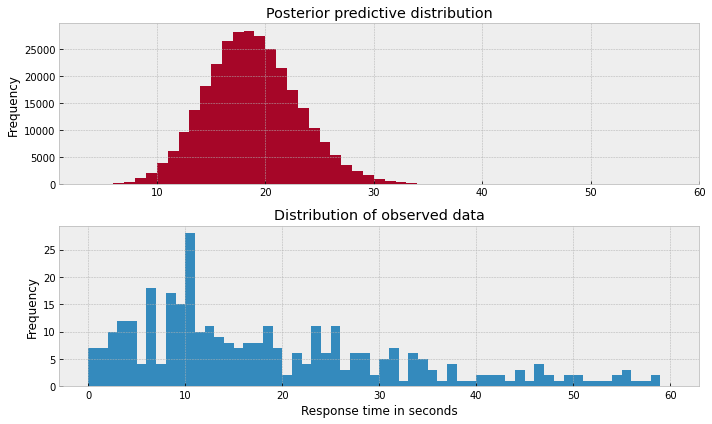

In [57]:
x_lim = 60
burnin = 50000

y_pred = trace[burnin:].get_values('y_pred')
mu_mean = trace[burnin:].get_values('mu').mean()

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
plt.xlim(1, x_lim)
plt.ylabel('Frequency')
plt.title('Posterior predictive distribution')

fig.add_subplot(212)

plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
plt.xlabel('Response time in seconds')
plt.ylabel('Frequency')
plt.title('Distribution of observed data')

plt.tight_layout()

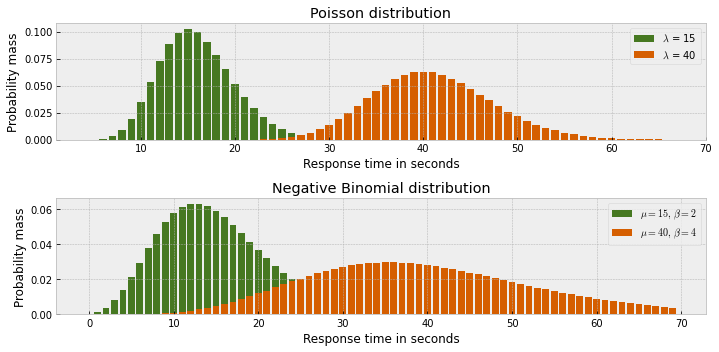

In [58]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(211)
x_lim = 70
mu = [15, 40]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[3])
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[4])
    
plt.xlim(1, x_lim)
plt.xlabel('Response time in seconds')
plt.ylabel('Probability mass')
plt.title('Poisson distribution')
plt.legend(['$\lambda$ = %s' % mu[0],
                '$\lambda$ = %s' % mu[1]])

# Scipy takes parameters n & p, not mu & alpha
def get_n(mu, alpha):
    return 1. / alpha * mu

def get_p(mu, alpha):
    return get_n(mu, alpha) / (get_n(mu, alpha) + mu)

fig.add_subplot(212)

a = [2, 4]

for i in np.arange(x_lim):
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[0], a[0]), p=get_p(mu[0], a[0])), color=colors[3])
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[1], a[1]), p=get_p(mu[1], a[1])), color=colors[4])

plt.xlabel('Response time in seconds')
plt.ylabel('Probability mass')
plt.title('Negative Binomial distribution')
plt.legend(['$\\mu = %s, \/ \\beta = %s$' % (mu[0], a[0]),
                '$\\mu = %s, \/ \\beta = %s$' % (mu[1], a[1])])

plt.tight_layout()

In [59]:
with pm.Model() as model:
    alpha = pm.Exponential('alpha', lam=.2)
    mu = pm.Uniform('mu', lower=0, upper=100)
    
    y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
    y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # Remove the CWD from sys.path while we load stuff.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [y_pred]
>Metropolis: [mu]
>Metropolis: [alpha]


Sampling 2 chains for 1_000 tune and 200_000 draw iterations (2_000 + 400_000 draws total) took 219 seconds.
The number of effective samples is smaller than 10% for some parameters.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


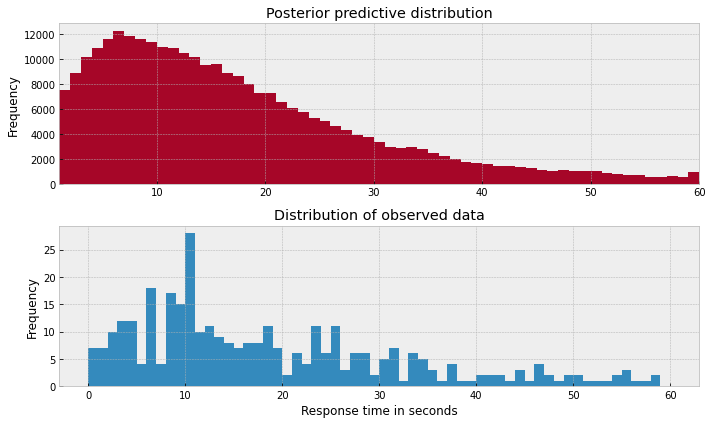

In [60]:
x_lim = 60
y_pred = trace[burnin:].get_values('y_pred')

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

fig.add_subplot(211)

plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
plt.xlim(1, x_lim)
plt.ylabel('Frequency')
plt.title('Posterior predictive distribution')

fig.add_subplot(212)

plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
plt.xlabel('Response time in seconds')
plt.ylabel('Frequency')
plt.title('Distribution of observed data')

plt.tight_layout()

## Model Checking II: Bayes Factor

In [65]:
with pm.Model() as model:
    
    # Index to true model
    prior_model_prob = 0.5
    #tau = pm.DiscreteUniform('tau', lower=0, upper=1)
    tau = pm.Bernoulli('tau', prior_model_prob)
    
    # Poisson parameters
    mu_p = pm.Uniform('mu_p', 0, 60)

    # Negative Binomial parameters
    alpha = pm.Exponential('alpha', lam=0.2)
    mu_nb = pm.Uniform('mu_nb', lower=0, upper=60)

    y_like = pm.DensityDist('y_like',
             lambda value: pm.math.switch(tau, 
                 pm.Poisson.dist(mu_p).logp(value),
                 pm.NegativeBinomial.dist(mu_nb, alpha).logp(value)
             ),
             observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step1 = pm.Metropolis([mu_p, alpha, mu_nb])
    step2 = pm.ElemwiseCategorical(vars=[tau], values=[0,1])
    trace = pm.sample(200000, step=[step1, step2], start=start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [mu_nb]
>>Metropolis: [alpha]
>>Metropolis: [mu_p]
>ElemwiseCategorical: [tau]


/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


Sampling 2 chains for 1_000 tune and 200_000 draw iterations (2_000 + 400_000 draws total) took 415 seconds.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f261d008750>,
      dtype=object)

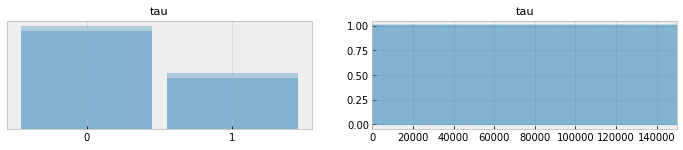

In [69]:
pm.plot_trace(trace[burnin:], var_names=['tau'])


In [67]:
# Compute the Bayes factor
prob_pois = trace[burnin:]['tau'].mean()
prob_nb = 1 - prob_pois
BF = (prob_nb/prob_pois)*(prior_model_prob/(1-prior_model_prob))
print("Bayes Factor: %s" % BF)

Bayes Factor: 1.891594135847092
